# Siamese Network

A Siamese neural network (sometimes called a twin neural network) is an artificial neural network that uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.

Often one of the output vectors is precomputed, thus forming a baseline against which the other output vector is compared. This is similar to comparing fingerprints but can be described more technically as a distance function for locality-sensitive hashing.

It is possible to make a kind of structure that is functional similar to a siamese network, but implements a slightly different function. This is typically used for comparing similar instances in different type sets.

Uses of similarity measures where a twin network might be used are such things as recognizing handwritten checks, automatic detection of faces in camera images, and matching queries with indexed documents. The perhaps most well-known application of twin networks are face recognition, where known images of people are precomputed and compared to an image from a turnstile or similar. It is not obvious at first, but there are two slightly different problems. One is recognizing a person among a large number of other persons, that is the facial recognition problem.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Siamese_neural_network)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, utils, callbacks

In [2]:
def make_pairs(images, labels, seed=19):
    np.random.seed(seed)
    pairImages = []
    pairLabels = []
    
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    
    return (np.array(pairImages), np.array(pairLabels))        

In [3]:
%%time

(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = 1 - (trainX / 255.0)
testX  = 1 - (testX / 255.0)

trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

print(f'\nTrain Data Shape: {pairTrain.shape}')
print(f'Test  Data Shape: {pairTest.shape}\n\n')

11493376/11490434 [==============================] - 0s 0us/step

Train Data Shape: (120000, 2, 28, 28, 1)
Test  Data Shape: (20000, 2, 28, 28, 1)


CPU times: user 8.81 s, sys: 558 ms, total: 9.37 s
Wall time: 9.63 s


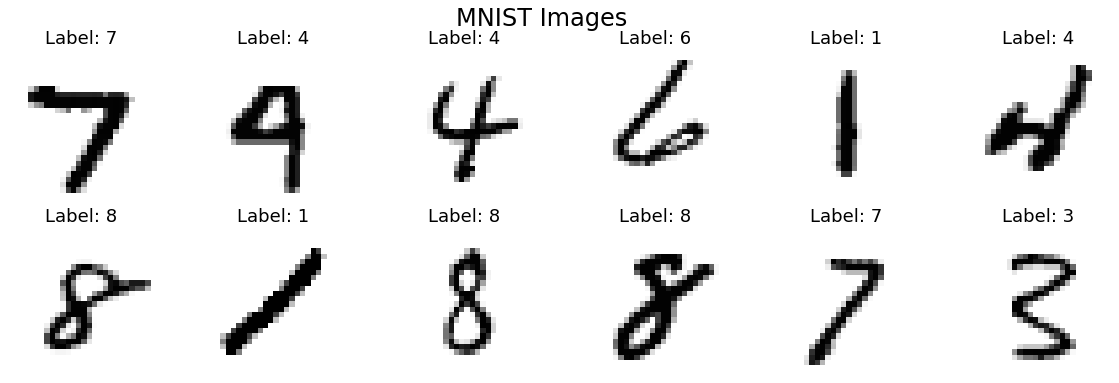

In [4]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(trainX)), k=12)
for i in range(12):
    ax[i//6][i%6].imshow(np.squeeze(trainX[idx[i]]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {trainY[idx[i]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
fig.suptitle('MNIST Images', fontsize=24);

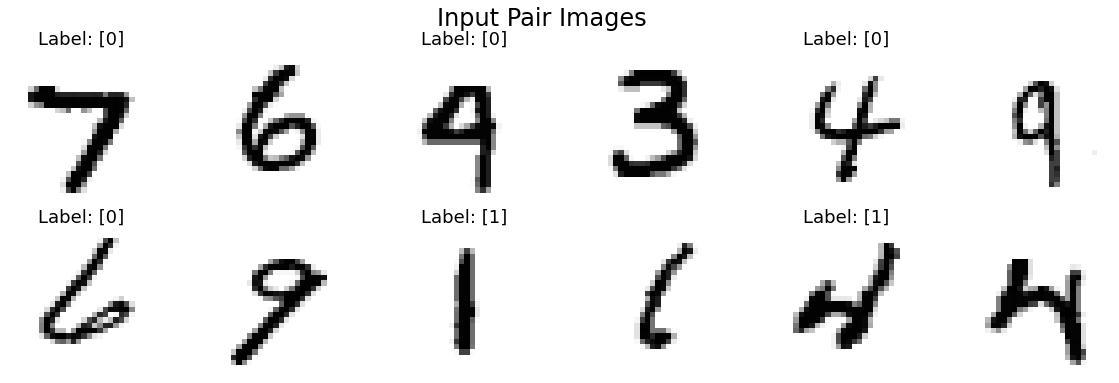

In [5]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(pairTrain)), k=6)
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(pairTrain[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(pairTrain[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTrain[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Input Pair Images', fontsize=24);

In [6]:
class config():
    IMG_SHAPE = (28, 28, 1)
    EMBEDDING_DIM = 48
    
    BATCH_SIZE = 64
    EPOCHS = 500

In [7]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [8]:
def loss(margin=1):
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [9]:
class SiameseNetwork(Model):
    def __init__(self, inputShape, embeddingDim):
        super(SiameseNetwork, self).__init__()
        
        imgA = layers.Input(shape=inputShape)
        imgB = layers.Input(shape=inputShape)
        featureExtractor = self.build_feature_extractor(inputShape, embeddingDim)
        featsA = featureExtractor(imgA)
        featsB = featureExtractor(imgB)
        distance = layers.Lambda(euclidean_distance, name='euclidean_distance')([featsA, featsB])
        outputs = layers.Dense(1, activation="sigmoid")(distance)
        self.model = Model(inputs=[imgA, imgB], outputs=outputs)        
        
    def build_feature_extractor(self, inputShape, embeddingDim=48):

        model = Sequential([
            layers.Input(inputShape),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
            layers.MaxPooling2D(pool_size=2),
            layers.Dropout(0.3),
            layers.Conv2D(128, (1, 1), padding="same", activation="relu"),
            layers.Flatten(),
            layers.Dense(embeddingDim, activation='tanh')
        ])

        return model  
        
    def call(self, x):
        return self.model(x)

model = SiameseNetwork(inputShape=config.IMG_SHAPE, embeddingDim=config.EMBEDDING_DIM)
model.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

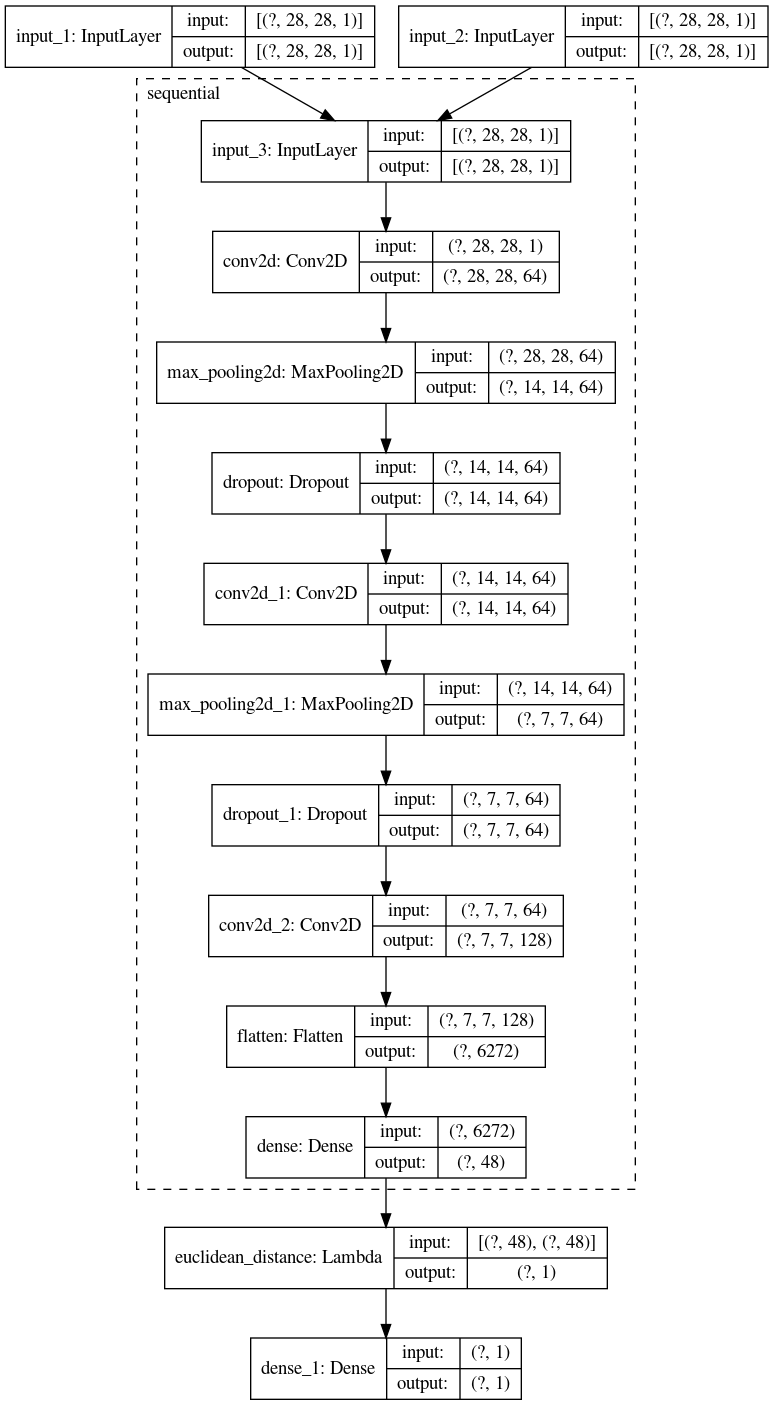

In [10]:
utils.plot_model(model.model, show_shapes=True, expand_nested=True)

In [11]:
es = callbacks.EarlyStopping(
    monitor='val_loss', patience=30, verbose=1, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, mode='min', verbose=1
)

history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=config.BATCH_SIZE, 
    epochs=config.EPOCHS,
    callbacks=[es, rlp]
)

Epoch 1/500
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1461 - accuracy: 0.7929 - val_loss: 0.0635 - val_accuracy: 0.9388
Epoch 2/500
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0551 - accuracy: 0.9409 - val_loss: 0.0416 - val_accuracy: 0.9560
Epoch 3/500
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0416 - accuracy: 0.9531 - val_loss: 0.0366 - val_accuracy: 0.9596
Epoch 4/500
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0316 - accuracy: 0.9639 - val_loss: 0.0219 - val_accuracy: 0.9757
Epoch 5/500
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0239 - accuracy: 0.9728 - val_loss: 0.0188 - val_accuracy: 0.9783
Epoch 6/500
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0211 - accuracy: 0.9754 - val_loss: 0.0174 - val_accuracy: 0.9798
Epoch 7/500
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0191 - accuracy: 0.9778 - val_loss: 0.0155 -

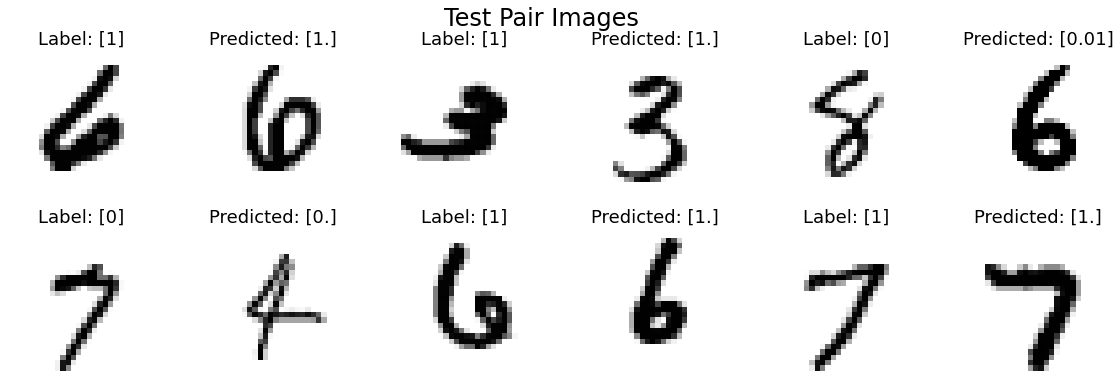

In [12]:
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
random.seed(19)
idx = random.choices(range(len(pairTest)), k=6)
preds = model.predict([pairTest[:, 0], pairTest[:, 1]])
for i in range(0, 12, 2):
    ax[i//6][i%6].imshow(np.squeeze(pairTest[idx[i//2]][0]), cmap='gray')
    ax[i//6][i%6+1].imshow(np.squeeze(pairTest[idx[i//2]][1]), cmap='gray')
    ax[i//6][i%6].set_title(f'Label: {labelTest[idx[i//2]]}', fontsize=18)
    ax[i//6][i%6+1].set_title(f'Predicted: {np.round(preds[idx[i//2]], 2)}', fontsize=18)
    ax[i//6][i%6].set_axis_off()
    ax[i//6][i%6+1].set_axis_off()
fig.suptitle('Test Pair Images', fontsize=24);

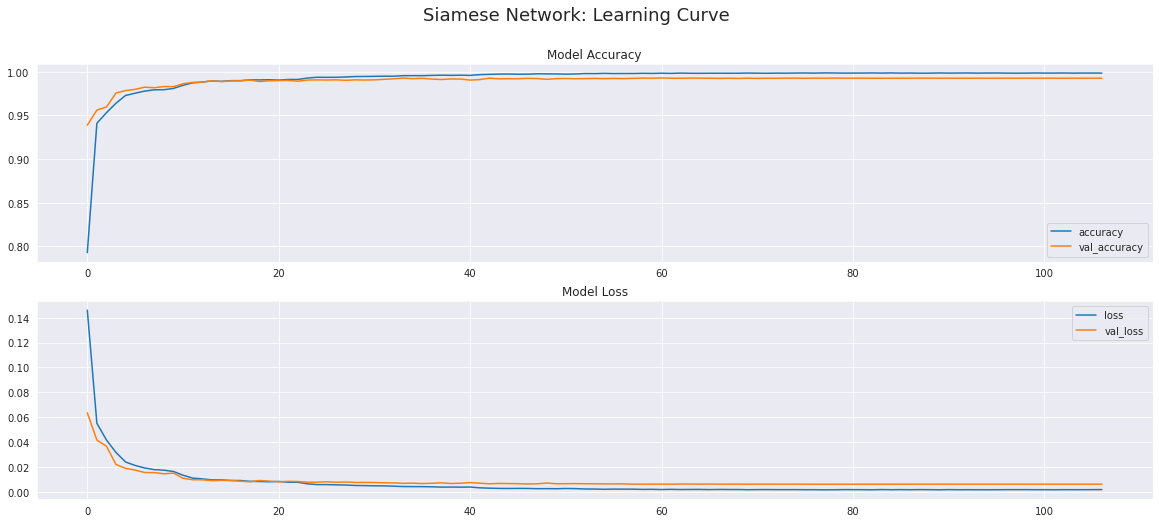

In [13]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Siamese Network: Learning Curve', fontsize=18);

# References
[Fisher Discriminant Triplet and Contrastive Losses for Training Siamese Networks](https://arxiv.org/pdf/2004.04674v1.pdf)